In [1]:
# import packages 
from bs4 import BeautifulSoup
from requests import get
import pandas as pd
from urllib.parse import urljoin
import time


<h1 style="color:red;">Question 1</h1>


The code below will get links to information about recent films from RottenTomatoes.com. 

Write some code to visit each film listed here and extract the critic rating (circled in red below) audience rating (circled in blue below), and plot synopsis (second image) for each film. Put your results in a data frame and convert the ratings to numeric variables.


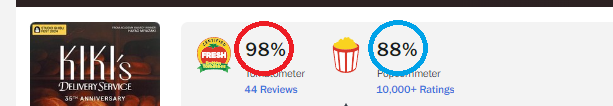

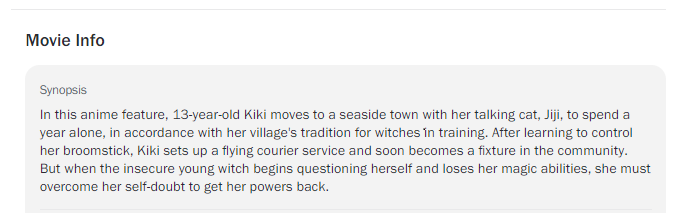

In [2]:
url = 'https://www.rottentomatoes.com/browse/movies_in_theaters/sort:newest'
# get site
site= get(url)
# parse the content
content = BeautifulSoup(site.content, 'html.parser')
# extract the links (urljoin turns them into absolute urls)
links = [urljoin(site.url, i.get('href')) for i  in content.select('.discovery-tiles a')]


In [3]:
movies = []
for i in links:
    movies.append(get(i))
    
    

Remember that you should always start with a single result, figure out how to format it into a dictionary, and then wrap that code in a function. This is much easier than trying to do everything in one step. 

## Selectors that work: 




In [17]:

site = movies[1]
content = BeautifulSoup(site.content, 'html.parser')

### Title

I think SelectorGadget may have given you some inaccurate information here regarding the title, but keep in mind you don't actually need to get the title from this page because you've already got a separate data frame with the title included. So you could ignore this entirely and then just get the title from that data frame.

(alternatively, you could use a different parser. The selectorGadget expression is actually fine if you use the lxml one instead of 'html.parser')



In [18]:
print(content.select_one('rt-text:nth-child(1)').get_text(), # basically just matches the first <rt-text> element
      content.select_one('rt-text[slot="title"]').get_text(), # matches <rt-text slot="title">      
     )

Heretic Heretic


### Critic and audience rating

Remember that you also needed to get rid of the '%' here and convert the result to numeric, but you can choose to do that in this step, or after you've created the data frame.

In [19]:
# critics
print(content.select_one('rt-button:nth-child(3) rt-text').get_text(), # the first rt-text element descended from the third rt-button element
      content.select_one('rt-button[slot="criticsScore"] rt-text').get_text()) # the first rt-text element descendent from an element like rt-button[slot="criticsScore"]b

95% 95%


In [29]:
# converting to numeric (could also use "float" or "int" here, but this may give errors on empty data)
pd.to_numeric(content.select_one('rt-button:nth-child(3) rt-text').get_text().replace('%',''))

95

### Synopsis

The synopsis value gave some people problems because there were a handful of cases where this element was absent, and so you got an error message when using `get_text()`. One solution to this would be to use an ifelse statement. Here are some potential work arounds: 



In [11]:
# using select instead of select_one, and then using get_text() on the resulting list object 

# no error even for non-existent elements: 
' '.join([i.get_text() for i in content.select('non-existent-element')])

# but still extracts if there's a match
' '.join([i.get_text() for i in content.select('rt-text[data-qa="synopsis-value"]')])


"A young family's life unravels into chaos as a sinister presence targets each member in its own malicious manner. Through the lens of police evidence, Mark, Diana, and Mia endure the torment of a demon deeply rooted in Greek mythology."

In [12]:
# using an inline if else statement. (The if condition here returns false if the element is NoneType
content.select_one('non-existent-element').get_text() if content.select_one('non-existent-element')  else ""

content.select_one('rt-text[data-qa="synopsis-value"]').get_text() if content.select_one('rt-text[data-qa="synopsis-value"]')  else ""

"A young family's life unravels into chaos as a sinister presence targets each member in its own malicious manner. Through the lens of police evidence, Mark, Diana, and Mia endure the torment of a demon deeply rooted in Greek mythology."

In [13]:
# making a function 

def conditional_get_text(selection):
    """
    Applies get_text() only if selected element is found, otherwise returns an empty string
    """
    if selection is None: 
        return ""
    else: 
        return selection.get_text()

conditional_get_text(content.select_one('non-existent-element'))

conditional_get_text(content.select_one('rt-text[data-qa="synopsis-value"]'))


"A young family's life unravels into chaos as a sinister presence targets each member in its own malicious manner. Through the lens of police evidence, Mark, Diana, and Mia endure the torment of a demon deeply rooted in Greek mythology."

## The function

In [27]:

def movie_parser(resp):
    """
    Converts a page for a single movie on Rotten Tomatoes into a dictionary
    
    """
    content = BeautifulSoup(resp.content, 'html.parser')
    
    res = {
        'link': resp.url,
        'title' : content.select_one('rt-text[slot="title"]').get_text(),
        'rating' :content.select_one('rt-button[slot="criticsScore"] rt-text').get_text(),
        'audience' : content.select_one('rt-button:nth-child(7) rt-text').get_text(),
        'synopsis': ' '.join([i.get_text() for i in content.select('rt-text[data-qa="synopsis-value"]')]),
        

          }
    # converting to numeric values: 
    res['rating'] =pd.to_numeric(res['rating'].replace('%', ''))
    res['audience'] =pd.to_numeric(res['audience'].replace('%', ''))

    
    
    return res


In [28]:
movie_df = pd.DataFrame([movie_parser(i) for i in movies])

In [16]:
movie_df

,link,title,rating,audience,synopsis
0,https://www.rottentomatoes.com/m/its_name_was_...,Its Name Was Mormo,NaN,NaN,A young family's life unravels into chaos as a...
1,https://www.rottentomatoes.com/m/heretic_2024,Heretic,95.0,NaN,Two young missionaries are forced to prove the...
2,https://www.rottentomatoes.com/m/small_things_...,Small Things Like These,90.0,NaN,Small Things Like These takes place over Chris...
3,https://www.rottentomatoes.com/m/the_best_chri...,The Best Christmas Pageant Ever,NaN,100.0,The Herdmans are absolutely the worst kids in ...
4,https://www.rottentomatoes.com/m/the_piano_lesson,The Piano Lesson,94.0,NaN,Set in 1936 Pittsburgh during the aftermath of...
5,https://www.rottentomatoes.com/m/elevation,Elevation,NaN,NaN,"Set in the post-apocalyptic Rocky Mountains, a..."
6,https://www.rottentomatoes.com/m/a_sudden_case...,A Sudden Case of Christmas,NaN,NaN,Lawrence Armanetti (Danny DeVito) runs a grand...
7,https://www.rottentomatoes.com/m/christmas_eve...,Christmas Eve in Miller's Point,90.0,NaN,"In CHRISTMAS EVE IN MILLER’S POINT, a rambunct..."
8,https://www.rottentomatoes.com/m/weekend_in_ta...,Weekend in Taipei,NaN,NaN,"Years ago, committed DEA agent John Lawlor fel..."
9,https://www.rottentomatoes.com/m/bird_2024,Bird,76.0,NaN,The long-awaited return to fiction filmmaking ...
